In [1]:
import os
import glob
import uproot
import math
# mpl.rcParams['figure.dpi'] = 150

import numpy as np
import matplotlib.pyplot as plt

# from sklearn.neighbors import NearestNeighbors

from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from ipyfilechooser import FileChooser
from ordered_set import OrderedSet
from plotting_utils import get_results, Result, unravel_weights
from typing import Tuple, List
from functools import cache
import yaml
from omegaconf import OmegaConf

%matplotlib inline
import mpld3
mpld3.enable_notebook()

Required Modules:
- `uproot`          # For reading root files
- `awkward`         # For array manipulation with jagged data
- `matplotlib`      # For plotting
- `notebook`         # For notebooks
- `ipyfilechooser`  # For file selector widget
- `mpld3`           # For plot inspecting
- `ordered-set`     # For easy creation of mass and vev lists from list of directories
- `pyaml`           # For reading yaml cfg files
- `seaborn`         # For heatmaps
- `numpy`           # For general array manipulation

In [2]:

def get_vevs_and_masses(sample_folder: str) -> Tuple[OrderedSet]:
    """
    Function to parse a sample folder to extract names of all subfolders and obtain the corresponding
    vevd-mdpp pairs. 
    Use OrderedSet module for this (standard sets do not preserve order of elements for performance reasons)
    (Use `pip install ordered-set` to install this module to your system) 

    Args:
        sample_folder (str): Path to sample folder containing multirun output

    Returns:
        Tuple[OrderedSet]: vevds, mdpps - a Tuple of OrderedSets containing the available vevd and mass pairs
    """
    
    folders = [p for p in glob.glob(f"{sample_folder}/*") if os.path.isdir(p)]
    vevds = []
    mdpps = []
    for fpath in folders:
        split_path = os.path.basename(fpath).split("_")
        vevds.append(float(split_path[-1]))
        mdpps.append(float(split_path[-2]))
    
    vevds.sort()
    mdpps.sort()
    vevds = OrderedSet(vevds)
    mdpps = OrderedSet(mdpps)
    
    return vevds, mdpps


In [3]:
def get_optimal_numuber_of_bins(data, m=2):
    """
    Compute the optimal number of bins for a given histogram using the "Goldilocks" statistic derived from the Shannon entropy of the histogram
    See: https://arxiv.org/abs/2210.02848
    Args:
        data (np.ndarray): 
        m (int, optional): "Goldilocks" statistic, 2<=M<=3. Defaults to 2.

    Returns:
        int: optimal number of bins
    """

    if 2 > m or m > 3: raise ValueError("'Goldilocks' statistic M must be 2<=M<=3")

    data_range = (np.amax(data) - np.amin(data))
    optimal_bin_width = data_range / len(data)**(1/m)
    optimal_numuber_of_bins = data_range // optimal_bin_width
    return int(optimal_numuber_of_bins)

def compute_goldilocks_param(histogram):
    # data = np.asarray(np.ravel(input_data)).reshape(-1, 1) # Wrangle data into correct shape
    # gamma = 0.5772156649 # Euler-Mascheroni constant
    # nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)
    # distances, indices = nbrs.kneighbors(data)
    # h_bins = math.log(2 * (nbins - 1)) + (gamma / math.log(2)) + (1 / nbins) * sum([math.log(xi[1], 2) for xi in distances])
    # bin_width = (np.amax(data) - np.amin(data)) // nbins
    # h = 2**h_bins
    # x = sum([math.log(xi[1]) for xi in distances])
    # print("sum([math.log(xi[1]) for xi in distances]) = ", x)
    # mx = math.log(nbins) / math.log(bin_width / h)

    # data = np.asarray(np.ravel(input_data)) # Wrangle data into correct shape
    # hx = - sum([xj * (j / nbins) * math.log(j / nbins) for xj, j in enumerate(data)])
    # mx = math.log(nbins) / hx
    # hx = math.log(nbins / np.amax(input_data), 2)

    N = sum(histogram)
    H = -1 * sum([(ni / N) * math.log(ni / N) for ni in histogram if ni > 0])
    mx = math.log(N) / H

    # print(f"N = {N}, log(N) = {math.log(N)}")

    return mx


In [25]:
def delta_yjj(data):
    j1_rap = data['jet_rap'].array()[:, 0]
    j2_rap = data['jet_rap'].array()[:, 1]
    dyjj = j1_rap - j2_rap
    return dyjj

def delta_phijj(data):
    j1_phi = data['jet_phi'].array()[:, 0]
    j2_phi = data['jet_phi'].array()[:, 1]
    dphijj = j1_phi - j2_phi
    return dphijj


def delta_rjj(data):
    dyjj = delta_yjj(data)
    dphijj = delta_phijj(data)
    return np.sqrt(dyjj**2 + dphijj**2)



In [22]:
#TODO: Could expand this with additional functions DeltaR etc...
special_obs = {'delta_Yjj': delta_yjj,
               'delta_phijj': delta_phijj,
               'delta_Rjj': delta_rjj,
               'jet1_pt': lambda data: data['jet_pt'].array()[:, 0],
               'jet2_pt': lambda data: data['jet_pt'].array()[:, 1],
               
               }

In [6]:
@cache
def get_observable(rootfile, obs, obj_num=0):
    data = uproot.open(f"{rootfile}:tree")
    weights = data['weight'].array()
    xsec = float(uproot.open(f"{rootfile}:metadata")['fid_xs'].array())

    if obs in special_obs.keys():
        arr = special_obs[obs](data)
    else:
        arr = data[obs]
        if obj_num > 0:
            arr = arr[:, obj_num-1]
    
    
    weights = unravel_weights(data, weights)
    arr = np.ravel(data)

    return arr, weights # , xsec
    

def plot_hists(results, background_files, obs, bins=None, normed=True, obj_num=0):
    fig, ax = plt.subplots()
    cm = plt.get_cmap('gist_rainbow');
    ncolors = len(results);
    ax.set_prop_cycle(color=[cm(1.*i/ncolors) for i in range(ncolors)]);
    
    signal_data = []
    signal_weights = []
    signal
    for r in results:
        signal[f"vevd={r.vevd}  mass={r.mdpp}"] = get_observable(r.file, obs, obj_num=obj_num)
    
    
    

In [23]:
# TODO Yes this is gross code - will improve!
class PlotSampleFolderWidget(widgets.VBox):

    def __init__(self):
        
        self.results = []
        self.avail_branches = []
        self.figs = {}
        self.out_widg = widgets.Output()
        align_kw = dict(_css = (('.widget-label', 'min-width', '20ex'),), margin = '0px 0px 5px 12px')
        
        self.file_widg = FileChooser("../multirun", show_only_dirs=True, **align_kw)

        
        #TODO: Would have some custom filename parser to automatically generate these parameter dropdowns
        self.vevd_widg = widgets.SelectMultiple( description='vevd', disabled=False, **align_kw)
        self.mass_widg = widgets.SelectMultiple( description='masses', disabled=False, **align_kw)
        self.branch_widg = widgets.SelectMultiple( description='observable', disabled=False, **align_kw)
        self.object_number_widg = widgets.SelectMultiple( description='object', value=[0], options=[0, 1, 2, 3], disabled=False, **align_kw)
        self.param_select_widg = widgets.HBox(children=[self.vevd_widg, self.mass_widg, self.branch_widg, self.object_number_widg])
        
        self.norm_widg = widgets.RadioButtons(options=['Unity', 'Xsec', 'None'], value='Unity', description='Normalisation', disabled=False, **align_kw)
        self.bin_widg = widgets.RadioButtons(options=['Auto', 'Manual'], value='Auto', description='Binning', disabled=False, **align_kw)

        self.xscale_widg = widgets.Checkbox(value=False, description='x-axis Logscale', disabled=False, **align_kw)
        self.yscale_widg = widgets.Checkbox(value=False, description='y-axis Logscale', disabled=False, **align_kw)
        self.scale_widg = widgets.VBox(children = [self.xscale_widg, self.yscale_widg], **align_kw)
        
        self.manual_bin_widg = widgets.IntText(value=50, description='Bins:', disabled=False, **align_kw)
        self.manual_bin_widg.layout.visibility = 'hidden'

        self.goldilocks_slider = self.xrange_widg = widgets.FloatSlider(value=2, min=2., max=+3., step=0.001, description='M:', readout_format='.001f',)
        self.goldilocks_slider.layout.visibility = 'visible'

        self.bin_widg_opts = widgets.VBox(children=[self.goldilocks_slider, self.manual_bin_widg])
        
        self.bin_widg.observe(self._show_binning_opts_widget, 'value')
        
        self.plot_opts_widg = widgets.HBox(children=[self.norm_widg, self.bin_widg, self.bin_widg_opts, self.scale_widg])
    
        self.plot_widg = widgets.Button(description="Plot")
        self.save_widg = widgets.Button(description="Save")
        self.plot_and_save_widg = widgets.VBox(children = [self.plot_widg, self.save_widg])

        self.plot_widg.on_click(self._plot)
        self.save_widg.on_click(self._save)
        
        display(self.out_widg)

        self.selectors = [self.file_widg, self.param_select_widg, self.plot_opts_widg, self.plot_and_save_widg]
        super().__init__(children=self.selectors)

        self._update_sample_path()    
        self.file_widg.register_callback(self._set_observes)
        
        self._set_observes()

        self.background_files = ["../generate_output/2023-03-20_08-40-23_SM_ssWW_QCD/output.root",
                                "../generate_output/2023-03-20_08-40-35_SM_ssWW_EWK/output.root",
                                "../generate_output/2023-03-20_08-40-43_SM_ssWW_INT/output.root"
                                ]

    def _plot(self, b):
        self.plot_selection()
    
    def _show_binning_opts_widget(self, b):
        if self.bin_widg.value == "Manual":
            self.manual_bin_widg.layout.visibility = 'visible'
            self.goldilocks_slider.layout.visibility = 'hidden'
            return
        self.manual_bin_widg.layout.visibility = 'hidden'
        self.goldilocks_slider.layout.visibility = 'visible'
    
    def _save(self, b):
        subfolder = os.path.basename(self.sample_folder)
        os.makedirs(f"plots/{subfolder}", exist_ok=True)
        [fig.savefig(f"plots/{subfolder}/{name}.png", dpi=300, bbox_inches='tight') for name, fig in self.figs.items()]

    def _update_sample_path(self):
        self.file_widg.refresh()
        self.sample_folder = self.file_widg.selected_path
        self.vevds, self.masses = get_vevs_and_masses(self.sample_folder)

        self.vevd_widg.options = self.vevds
        self.mass_widg.options = self.masses
    
    def _update_results_list(self):
        
        self.results = []
        root_files = glob.glob(f"{self.sample_folder}/*/output.root")
        
        for fpath in root_files:
            split_path = os.path.basename(os.path.dirname(fpath)).split("_")
            vevd = float(split_path[-1])
            mass = float(split_path[-2])

            if vevd in self.vevd_widg.get_interact_value() and mass in self.mass_widg.get_interact_value():
                self.results.append(Result(vevd, mass, file=fpath))
        
        if len(root_files) != 0:
            data = uproot.open(f"{root_files[0]}:tree")
            self.avail_branches = list(data.keys()) + list(special_obs.keys())
            self.branch_widg.options = self.avail_branches

    def _set_observes(self):
        self._update_sample_path()
        self._update_results_list()

        for widg in self.selectors:
            widg.observe(self._observed_function, names='value')


    def _observed_function(self, widg):
        self.sample_folder = self.file_widg.selected_path
        self._update_sample_path()
        self._update_results_list()

    def _plot_selected_obs(self, root_files, obs, object_number):

        fig, ax = plt.subplots();
        cm = plt.get_cmap('gist_rainbow');
        ncolors = len(root_files);
        ax.set_prop_cycle(color=[cm(1.*i/ncolors) for i in range(ncolors)]);
        
        hists = {}

        for r in self.results:
            data, bins, weight = self._make_hist(ax, r, obs, bins=self.bin_widg.value, object_number=object_number);
            hists[f'vevd={r.vevd}  mass={r.mdpp}'] = (data, bins, weight)


        if self.xscale_widg.value:
            ax.set_xscale('log')
        
        if self.yscale_widg.value:
            ax.set_yscale('log')

        bkg_hists = {}

        #TODO: Idea here woule be to have these configured in a config file
        ssww_file = '/home/bewilson/MadHydra/generate_output/2023-03-29_03-54-31_SM_ssWW_EWK/output.root'
        bkg_hists['ssWW EWK'] = self._make_hist(ax, None, obs, bins=self.bin_widg.value, object_number=object_number, label='ssWW EWK', background_file=ssww_file, histtype='stepfilled', stacked=True, color='dodgerblue');

        ssww_int_file = '/home/bewilson/MadHydra/generate_output/2023-03-29_09-43-53_SM_ssWW_INT/output.root'
        bkg_hists['ssWW INT'] = self._make_hist(ax, None, obs, bins=self.bin_widg.value, object_number=object_number, label='ssWW INT', background_file=ssww_int_file, histtype='stepfilled', stacked=True, color='powderblue');

        ssww_qcd_file = '/home/bewilson/MadHydra/generate_output/2023-03-29_11-00-45_SM_ssWW_QCD/output.root'
        bkg_hists['ssWW QCD'] = self._make_hist(ax, None, obs, bins=self.bin_widg.value, object_number=object_number, label='ssWW QCD', background_file=ssww_qcd_file, histtype='stepfilled', stacked=True, color='deepskyblue');


        histdata = []
        weights = []
        binslist = []
        labels = []
        for name, (data, bins, weight) in hists.items():
            histdata.append(data)
            weights.append(weight)
            binslist.append(bins)
            labels.append(name)

        bkg_histdata = []
        bkg_weights = []
        bkg_binslist = []
        bkg_labels = []
        for name, (data, bins, weight) in bkg_hists.items():
            bkg_histdata.append(data)
            bkg_weights.append(weight)
            bkg_binslist.append(bins)
            bkg_labels.append(name)
        
        density = False
        if self.norm_widg.value == 'Unity':
            density = True

        ax.hist(histdata, np.amin(binslist), density=density, histtype='step', label=labels, weights=weights)

        ax.hist(bkg_histdata, np.amin(bkg_binslist), density=density, histtype='stepfilled', label=bkg_labels, weights=bkg_weights, stacked=True, color=['dodgerblue', 'powderblue', 'deepskyblue'])

        ax.legend(loc='upper left', bbox_to_anchor=(1.04, 1));
        ax.set_xlabel(obs);
        fig.subplots_adjust(right=0.7)
        display(fig)
        plt.close('all');
        
        self.figs[obs] = fig

    def plot_selection(self):
        
        self._update_results_list()
        root_files = [r.file for r in self.results]

        if len(root_files) == 0: 
            print("No rooot files found", self.results)
            return

        selected_obs = self.branch_widg.get_interact_value()
        selected_objects = self.object_number_widg.get_interact_value()

        with self.out_widg:
            for i, obs in enumerate(selected_obs):
                for object_num in selected_objects:
                    self._plot_selected_obs(root_files, obs, object_num)

            self.out_widg.clear_output(wait=True)
            
        
    def _make_hist(self, ax, result, obs, bins=50, label=None, object_number=0, background_file=None, histtype='step', stacked=False, color=None):
        
        if background_file is not None:
            file =  background_file
        elif result is not None:
            file = result.file

        tree = uproot.open(f"{file}:tree");
        metadata = uproot.open(f"{file}:metadata");

        if obs in special_obs.keys():
            data = np.ravel(special_obs[obs](tree));
            weight = tree['weight'].array(library='np')
        else:
            data = np.ravel(tree[obs].array());
        
        if object_number > 0:
            data_cut = np.ravel(data[..., object_number-1])
            weight = tree['weight'].array(library='np')
            data = data_cut
        elif obs not in special_obs.keys():
            weight = unravel_weights(tree[obs].array(), tree['weight'].array()) 

        if label is None:
            label = f"vevd={result.vevd}  mass={result.mdpp}";

        density = False
        if self.norm_widg.value == 'Unity':
            # weight = np.ones_like(data)
            density = True
        elif self.norm_widg.value == 'Xsec':
            weight = weight * metadata['fid_xs'] / metadata['total_xs'] * 140
        elif self.norm_widg.value == 'None':
            weight = np.ones_like(weight)
            print(weight)
        
        if self.bin_widg.value == 'Auto':
            bins = get_optimal_numuber_of_bins(data, m=self.goldilocks_slider.value)
        elif self.bin_widg.value == 'Manual':
            bins = self.manual_bin_widg.value

        # hist, _, _ = ax.hist(data, bins, label=label, density=density, weights=weight, histtype=histtype, stacked=stacked, color=color)
        return data, bins, weight
        # return ax


In [8]:
p = "/home/bewilson/MadHydra/multirun/2023-03-20_single_production_inclusive/single_production_inclusive_100_0.1/.hydra/overrides.yaml"
list_cfg = OmegaConf.load(p)
print(list_cfg)

['+process=typeII_vbs_inclusive', 'parameters.log10_vevD=-1', 'parameters.MDPP=100', 'batch=True']


To use this widget start with the `Select` button at the top to choose the directory. By default this should point to `multirun`. Once you have done that select a folder and then press `Select`. You can then select from the drop down menus which vevs and masses you'd like to plot, (you can use `shift` and`alt` like you would in file explorer).
You can then select from the list of observables you'd like to plot (again you can select multiple).
There are other options for selecting the binning (the `M` slider is WIP, ignore), normalisation etc...
To plot the histograms press the `Plot` button, to save them press `Save` (these are then saved to `notebooks/plots/<sample-folder-name>`).
You can explore the plots by clicking on the little four-way arrow icon in the bottom left, using the mouse/touchpad you can zoom in and move around the plot.

Output()

PlotSampleFolderWidget(children=(FileChooser(path='/home/bewilson/MadHydra/multirun', filename='', title='', s…

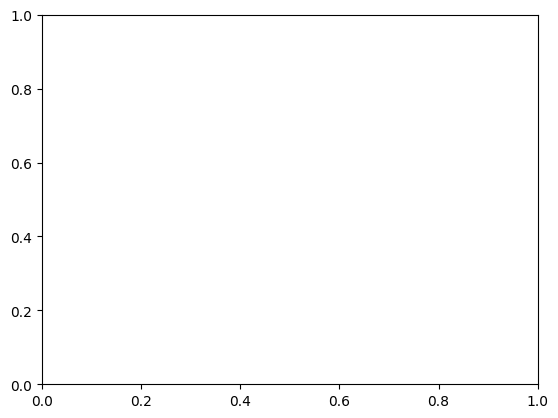

In [24]:
PlotSampleFolderWidget()

In [ ]:
import ordered_set
def override_resolver(sample_folders):
    
    override_cfgs = [os.path.join(p, '.hydra', 'overrides.yaml') for p in sample_folders]

    params_and_values = {}

    for cfg in override_cfgs:
        list_cfg = OmegaConf.load(cfg)
        for override in list_cfg:
            if 'parameters' in override:
                param_name, param_value = override.split('=')
                param_name = param_name.replace("parameters.", "")

            if param_name not in params_and_values.keys():
                params_and_values[param_name] = []
            params_and_values[param_name].append(float(param_value))

    for param_name in params_and_values.keys():
        params_and_values[param_name] = OrderedSet(sorted(params_and_values[param_name]))
    
    return params_and_values


class ParameterSelector(widgets.HBox):

    def __init__(self, sample_folders, resolver):

        children = self.init(sample_folders, resolver)

        super().__init__(children=children)

    def update(self, sample_folders, resolver):

        params_and_values = resolver(sample_folders)

        children = []

        for param, values in params_and_values:
            if len(values) > 1:
                children.append(widgets.SelectMultiple(description=param, options=values, disabled=False))

        return children


class BranchSelector(widgets.SelectMultiple):

    def __init__(self, sample_folders, special_obs={}, target_filename='output.root'):
        self.special_obs = special_obs

    def update(self, sample_folder, target_filename='output.root'):
                

class PlotSampleFolderWidget2(widgets.VBox):

    def __init__(self):
        
        self.results = []
        self.avail_branches = []
        self.figs = {}

        self.out_widg = widgets.Output()
        align_kw = dict(_css = (('.widget-label', 'min-width', '20ex'),), margin = '0px 0px 5px 12px')
        
        self.file_widg = FileChooser("../multirun", show_only_dirs=True, **align_kw)

        
        #TODO: Would have some custom filename parser to automatically generate these parameter dropdowns
        self.vevd_widg = widgets.SelectMultiple( description='vevd', disabled=False, **align_kw)
        self.mass_widg = widgets.SelectMultiple( description='masses', disabled=False, **align_kw)
        self.branch_widg = widgets.SelectMultiple( description='observable', disabled=False, **align_kw)
        self.object_number_widg = widgets.SelectMultiple( description='object', value=[0], options=[0, 1, 2, 3], disabled=False, **align_kw)
        self.param_select_widg = widgets.HBox(children=[self.vevd_widg, self.mass_widg, self.branch_widg, self.object_number_widg])
        
        self.norm_widg = widgets.RadioButtons(options=['Unity', 'Xsec', 'None'], value='Unity', description='Normalisation', disabled=False, **align_kw)
        self.bin_widg = widgets.RadioButtons(options=['Auto', 'Manual'], value='Auto', description='Binning', disabled=False, **align_kw)

        self.xscale_widg = widgets.Checkbox(value=False, description='x-axis Logscale', disabled=False, **align_kw)
        self.yscale_widg = widgets.Checkbox(value=False, description='y-axis Logscale', disabled=False, **align_kw)
        self.scale_widg = widgets.VBox(children = [self.xscale_widg, self.yscale_widg], **align_kw)
        
        self.manual_bin_widg = widgets.IntText(value=50, description='Bins:', disabled=False, **align_kw)
        self.manual_bin_widg.layout.visibility = 'hidden'

        self.goldilocks_slider = self.xrange_widg = widgets.FloatSlider(value=2, min=2., max=+3., step=0.001, description='M:', readout_format='.001f',)
        self.goldilocks_slider.layout.visibility = 'visible'

        self.bin_widg_opts = widgets.VBox(children=[self.goldilocks_slider, self.manual_bin_widg])
        
        self.bin_widg.observe(self._show_binning_opts_widget, 'value')
        
        self.plot_opts_widg = widgets.HBox(children=[self.norm_widg, self.bin_widg, self.bin_widg_opts, self.scale_widg])
    
        self.plot_widg = widgets.Button(description="Plot")
        self.save_widg = widgets.Button(description="Save")
        self.plot_and_save_widg = widgets.VBox(children = [self.plot_widg, self.save_widg])

        self.plot_widg.on_click(self._plot)
        self.save_widg.on_click(self._save)
        
        display(self.out_widg)

        self.selectors = [self.file_widg, self.param_select_widg, self.plot_opts_widg, self.plot_and_save_widg]
        super().__init__(children=self.selectors)

        self._update_sample_path()    
        self.file_widg.register_callback(self._set_observes)
        
        self._set_observes()

        self.background_files = ["../generate_output/2023-03-20_08-40-23_SM_ssWW_QCD/output.root",
                                "../generate_output/2023-03-20_08-40-35_SM_ssWW_EWK/output.root",
                                "../generate_output/2023-03-20_08-40-43_SM_ssWW_INT/output.root"
                                ]

    def _plot(self, b):
        self.plot_selection()
    
    def _show_binning_opts_widget(self, b):
        if self.bin_widg.value == "Manual":
            self.manual_bin_widg.layout.visibility = 'visible'
            self.goldilocks_slider.layout.visibility = 'hidden'
            return
        self.manual_bin_widg.layout.visibility = 'hidden'
        self.goldilocks_slider.layout.visibility = 'visible'
    
    def _save(self, b):
        subfolder = os.path.basename(self.sample_folder)
        os.makedirs(f"plots/{subfolder}", exist_ok=True)
        [fig.savefig(f"plots/{subfolder}/{name}.png", dpi=300, bbox_inches='tight') for name, fig in self.figs.items()]

    def _update_sample_path(self):
        self.file_widg.refresh()
        self.sample_folder = self.file_widg.selected_path
        self.vevds, self.masses = get_vevs_and_masses(self.sample_folder)

        self.vevd_widg.options = self.vevds
        self.mass_widg.options = self.masses
    
    def _update_results_list(self):
        
        self.results = []
        root_files = glob.glob(f"{self.sample_folder}/*/output.root")
        
        for fpath in root_files:
            split_path = os.path.basename(os.path.dirname(fpath)).split("_")
            vevd = float(f"{split_path[-1]:.2f}")
            mass = float(f"{split_path[-2]:.2f}")

            if vevd in self.vevd_widg.get_interact_value() and mass in self.mass_widg.get_interact_value():
                self.results.append(Result(vevd, mass, file=fpath))
        
        if len(root_files) != 0:
            data = uproot.open(f"{root_files[0]}:tree")
            self.avail_branches = list(data.keys()) + list(special_obs.keys())
            self.branch_widg.options = self.avail_branches

    def _set_observes(self):
        self._update_sample_path()
        self._update_results_list()

        for widg in self.selectors:
            widg.observe(self._observed_function, names='value')


    def _observed_function(self, widg):
        self.sample_folder = self.file_widg.selected_path
        self._update_sample_path()
        self._update_results_list()

    def _plot_selected_obs(self, root_files, obs, object_number):

        fig, ax = plt.subplots();
        cm = plt.get_cmap('gist_rainbow');
        ncolors = len(root_files);
        ax.set_prop_cycle(color=[cm(1.*i/ncolors) for i in range(ncolors)]);
        
        hists = {}

        for r in self.results:
            data, bins, weight = self._make_hist(ax, r, obs, bins=self.bin_widg.value, object_number=object_number);
            hists[f'vevd={r.vevd}  mass={r.mdpp}'] = (data, bins, weight)


        if self.xscale_widg.value:
            ax.set_xscale('log')
        
        if self.yscale_widg.value:
            ax.set_yscale('log')

        bkg_hists = {}

        #TODO: Idea here woule be to have these configured in a config file
        ssww_file = '/home/bewilson/MadHydra/generate_output/2023-03-29_03-54-31_SM_ssWW_EWK/output.root'
        bkg_hists['ssWW EWK'] = self._make_hist(ax, None, obs, bins=self.bin_widg.value, object_number=object_number, label='ssWW EWK', background_file=ssww_file, histtype='stepfilled', stacked=True, color='dodgerblue');

        ssww_int_file = '/home/bewilson/MadHydra/generate_output/2023-03-29_09-43-53_SM_ssWW_INT/output.root'
        bkg_hists['ssWW INT'] = self._make_hist(ax, None, obs, bins=self.bin_widg.value, object_number=object_number, label='ssWW INT', background_file=ssww_int_file, histtype='stepfilled', stacked=True, color='powderblue');

        ssww_qcd_file = '/home/bewilson/MadHydra/generate_output/2023-03-29_11-00-45_SM_ssWW_QCD/output.root'
        bkg_hists['ssWW QCD'] = self._make_hist(ax, None, obs, bins=self.bin_widg.value, object_number=object_number, label='ssWW QCD', background_file=ssww_qcd_file, histtype='stepfilled', stacked=True, color='deepskyblue');


        histdata = []
        weights = []
        binslist = []
        labels = []
        for name, (data, bins, weight) in hists.items():
            histdata.append(data)
            weights.append(weight)
            binslist.append(bins)
            labels.append(name)

        bkg_histdata = []
        bkg_weights = []
        bkg_binslist = []
        bkg_labels = []
        for name, (data, bins, weight) in bkg_hists.items():
            bkg_histdata.append(data)
            bkg_weights.append(weight)
            bkg_binslist.append(bins)
            bkg_labels.append(name)
        
        density = False
        if self.norm_widg.value == 'Unity':
            density = True

        ax.hist(histdata, np.amin(binslist), density=density, histtype='step', label=labels, weights=weights)

        ax.hist(bkg_histdata, np.amin(bkg_binslist), density=density, histtype='stepfilled', label=bkg_labels, weights=bkg_weights, stacked=True, color=['dodgerblue', 'powderblue', 'deepskyblue'])

        ax.legend(loc='upper left', bbox_to_anchor=(1.04, 1));
        ax.set_xlabel(obs);
        fig.subplots_adjust(right=0.7)
        display(fig)
        plt.close('all');
        
        self.figs[obs] = fig

    def plot_selection(self):
        
        self._update_results_list()
        root_files = [r.file for r in self.results]

        if len(root_files) == 0: 
            print("No rooot files found", self.results)
            return

        selected_obs = self.branch_widg.get_interact_value()
        selected_objects = self.object_number_widg.get_interact_value()

        with self.out_widg:
            for i, obs in enumerate(selected_obs):
                for object_num in selected_objects:
                    self._plot_selected_obs(root_files, obs, object_num)

            self.out_widg.clear_output(wait=True)
            
        
    def _make_hist(self, ax, result, obs, bins=50, label=None, object_number=0, background_file=None, histtype='step', stacked=False, color=None):
        
        if background_file is not None:
            file =  background_file
        elif result is not None:
            file = result.file

        tree = uproot.open(f"{file}:tree");
        metadata = uproot.open(f"{file}:metadata");

        if obs in special_obs.keys():
            data = np.ravel(special_obs[obs](tree));
            weight = tree['weight'].array(library='np')
        else:
            data = np.ravel(tree[obs].array());
        
        if object_number > 0:
            data_cut = np.ravel(data[..., object_number-1])
            weight = tree['weight'].array(library='np')
            data = data_cut
        elif obs not in special_obs.keys():
            weight = unravel_weights(tree[obs].array(), tree['weight'].array()) 

        if label is None:
            label = f"vevd={result.vevd}  mass={result.mdpp}";

        density = False
        if self.norm_widg.value == 'Unity':
            # weight = np.ones_like(data)
            density = True
        elif self.norm_widg.value == 'Xsec':
            weight = weight * metadata['fid_xs'] / metadata['total_xs'] * 140
        elif self.norm_widg.value == 'None':
            weight = np.ones_like(weight)
            print(weight)
        
        if self.bin_widg.value == 'Auto':
            bins = get_optimal_numuber_of_bins(data, m=self.goldilocks_slider.value)
        elif self.bin_widg.value == 'Manual':
            bins = self.manual_bin_widg.value

        # hist, _, _ = ax.hist(data, bins, label=label, density=density, weights=weight, histtype=histtype, stacked=stacked, color=color)
        return data, bins, weight
        # return ax
